In [1]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

import gym

In [2]:
# Load the environment
env = gym.make('CartPole-v1')
print(f"The observation space: {env.observation_space}")
print(f"The action space: {env.action_space}")

The observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
The action space: Discrete(2)


In [3]:
def init_fig(env):
    plt.figure()
    plt.title(f"{env.spec.id} | Episode: 0 | Step: 0 | Reward: 0.0")
    plt.axis('off')
    return plt.imshow(env.render(mode='rgb_array'))

def update_fig(img, env, episode, step, total_reward):
    plt.title(f"{env.spec.id} | Episode: {episode} | Step: {step} | Reward: {total_reward}")
    img.set_data(env.render(mode='rgb_array'))
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [4]:
import time
import numpy as np

def experiment(env, next_action, num_steps=1000, max_episodes=10, record_obs=False,
               visualize_in_notebook=True, sleep=0.01):
    # initialize counters
    episode = 1
    step = 0
    total_reward = 0.0
    episode_rewards = []

    # reset env
    obs = env.reset()

    # initialize figure in notebook
    if visualize_in_notebook:
        img = init_fig(env)
    
    # initialize recorder for observations (for STL)
    obs_records = []
    cur_record = []

    for _ in range(num_steps):
        if record_obs:
            cur_record.append(obs)
        
        action = next_action(obs)
        obs, reward, done, info = env.step(action)
        step += 1
        total_reward += reward

        if visualize_in_notebook:
            update_fig(img, env, episode, step, total_reward)
        else:
            env.render()

        if done:
            episode_rewards.append(total_reward)
            obs_records.append(cur_record)
            
            episode += 1
            step = 0
            total_reward = 0.0
            cur_record = []
            
            env.reset()
            
            if episode > max_episodes:
                break
            
            time.sleep(1)

        if sleep > 0.0:
            time.sleep(sleep)
    
    if len(episode_rewards) > 0:
        print(f"Rewards: {episode_rewards}")
        print(f"Mean reward of {len(episode_rewards)} completed episodes: {np.mean(episode_rewards)}")
        print(f"Std reward of {len(episode_rewards)} completed episodes: {np.std(episode_rewards)}")
    
    return obs_records

Rewards: [18.0, 19.0, 62.0]
Mean reward of 3 completed episodes: 33.0
Std reward of 3 completed episodes: 20.51016008388688


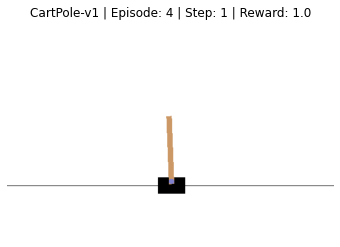

In [7]:
# Run the env by randoming sampling an action
_ = experiment(env, lambda obs: env.action_space.sample(), num_steps=100)

In [8]:
# Train a simple DQN
from stable_baselines3 import DQN

# model_dqn = DQN("MlpPolicy", env, verbose=1)
# model_dqn.learn(total_timesteps=100000)
# model_dqn.save("dqn_cartpole")

model_dqn = DQN.load("dqn_cartpole")

In [6]:
from stable_baselines3 import PPO

# model_ppo = PPO("MlpPolicy", env, verbose=1)
# model_ppo.learn(total_timesteps=20000)
# model_ppo.save("ppo_2_cartpole")

model_ppo = PPO.load("best_model")

NameError: name 'model_dqn' is not defined

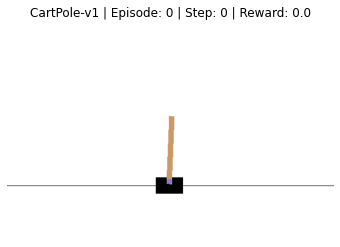

In [7]:
# Run the trained controller
_ = experiment(env, lambda obs: model_dqn.predict(obs)[0], num_steps=100)

Rewards: [500.0, 500.0]
Mean reward of 2 completed episodes: 500.0
Std reward of 2 completed episodes: 0.0


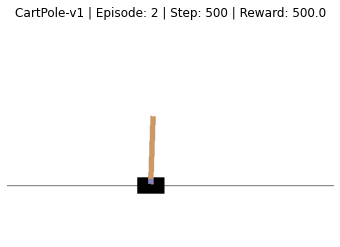

In [8]:
_ = experiment(env, lambda obs: model_ppo.predict(obs)[0], num_steps=1000)

In [9]:
env.close()

In [10]:
# Create a mutated environment
from gym.envs.classic_control import CartPoleEnv
from gym.wrappers.time_limit import TimeLimit
from types import SimpleNamespace

class MutatedCartPoleEnv(CartPoleEnv):
    def __init__(self, masscart = 1.0, masspole = 0.1, length = 0.5, force_mag = 10.0):
        super().__init__()
        
        self.spec = SimpleNamespace()
        self.spec.id = f"MutatedCartPole-{masscart}-{masspole}-{length}-{force_mag}"
        
        self.gravity = 9.8
        self.masscart = masscart
        self.masspole = masspole
        self.total_mass = self.masspole + self.masscart
        self.length = length  # actually half the pole's length
        self.polemass_length = self.masspole * self.length
        self.force_mag = force_mag
        self.tau = 0.02  # seconds between state updates

Rewards: [91.0]
Mean reward of 1 completed episodes: 91.0
Std reward of 1 completed episodes: 0.0


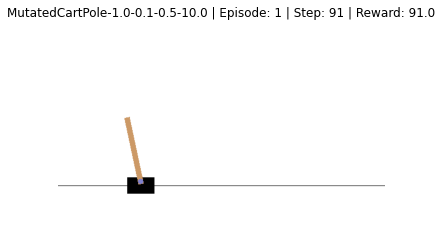

In [14]:
mutated_env1 = TimeLimit(MutatedCartPoleEnv(), max_episode_steps=500)
records1 = experiment(mutated_env1, lambda obs: model_ppo.predict(obs)[0],
                      sleep=0.0, num_steps=10_000, record_obs=True, max_episodes=1)
mutated_env1.close()

Rewards: [110.0]
Mean reward of 1 completed episodes: 110.0
Std reward of 1 completed episodes: 0.0


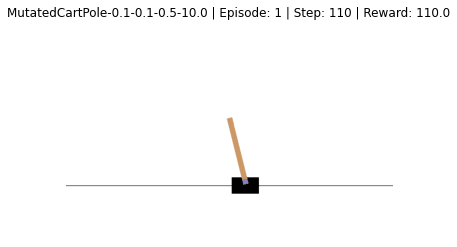

In [13]:
mutated_env2 = TimeLimit(MutatedCartPoleEnv(masscart=0.1), max_episode_steps=500)
records2 = experiment(mutated_env2, lambda obs: model_ppo.predict(obs)[0],
                      sleep=0.0, num_steps=10_000, record_obs=True, max_episodes=1)
mutated_env2.close()

In [16]:
import pandas as pd

data = pd.DataFrame(
    records1[0],
    columns=['Cart Position', 'Cart Velocity', 'Pole Angle', 'Angular Velocity']
); data[:5]

,Cart Position,Cart Velocity,Pole Angle,Angular Velocity
0,0.008016,0.021849,-0.020350,0.042467
1,0.008453,-0.172975,-0.019500,0.328661
2,0.004994,0.022419,-0.012927,0.029893
3,0.005442,-0.172515,-0.012329,0.318469
4,0.001992,0.022780,-0.005960,0.021923


<AxesSubplot:>

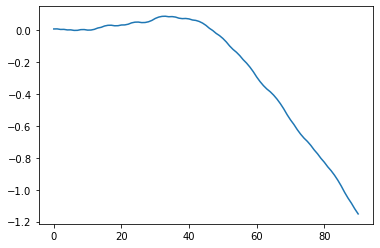

In [17]:
data['Cart Position'].plot()

<AxesSubplot:>

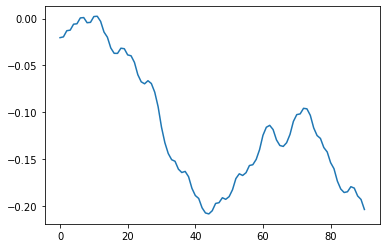

In [18]:
data['Pole Angle'].plot()

In [19]:
# Compute robustness value of the STL formula:
#   G ( pos > -2.4 & pos < 2.4 & angle > -12 degree & angle < 12 degree )
import signal_tl as stl
import math

pos = stl.Predicate('pos')
angle = stl.Predicate('angle')

pos_threshold = 2.4
angle_threshold = 12 * 2 * math.pi / 360

phi = stl.Always(
    (pos > -pos_threshold) &\
    (pos < pos_threshold) &\
    (angle > -angle_threshold) &\
    (angle < angle_threshold)
)

time_index = np.arange(len(data))
trace = {
    "pos": stl.Signal(data['Cart Position'], time_index),
    "angle": stl.Signal(data['Pole Angle'], time_index)
}

rob = stl.compute_robustness(phi, trace)
rob.at(0)

ModuleNotFoundError: No module named 'signal_tl'